In [ ]:
!pip -q install transformers datasets accelerate evaluate

# **# 1) LOAD DATA**

In [ ]:

import kagglehub
saurabhshahane_arabic_classification_path = kagglehub.dataset_download('saurabhshahane/arabic-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'arabic-classification' dataset.
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/arabic-classification/arabic_dataset_classifiction.csv/arabic_dataset_classifiction.csv


In [ ]:
import pandas as pd

file_path = "/kaggle/input/arabic-classification/arabic_dataset_classifiction.csv/arabic_dataset_classifiction.csv"
df = pd.read_csv(file_path)



# **IMPORTS**

In [ ]:
import re, string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, f1_score

# **READ THE DATA**

In [ ]:
df.head()

,text,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0


In [ ]:
df.tail()

,text,targe
111723,اللاعب تأخر في العودة إلى التداريب والمدرب غاض...,4
111724,المشرف العام لحسنية أكادير قال إنه سيغادر الفر...,4
111725,نسب إليه نتائج الوداد وصحوة الرجاء وآخر صيحاته...,4
111726,ستحتضن الرباط في الفترة مابين يوليوز المقبل دو...,4
111727,رضخ أحمد أهمو رئيس أمل تيزنيت لكرة القدم لضغوط...,4


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111728 entries, 0 to 111727
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    108789 non-null  object
 1   targe   111728 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
df.columns

Index(['text', 'targe'], dtype='object')

In [ ]:
df['targe'].value_counts()


,count
targe,
4,46522
3,20505
1,16728
2,14235
0,13738


In [ ]:
df.isnull().sum()

,0
text,2939
targe,0


In [ ]:
df.drop_duplicates(inplace=True)


In [ ]:
df["text"] = df["text"].astype(str)

df["targe"] = pd.to_numeric(df["targe"], errors="coerce")

df = df.dropna(subset=["targe"]).copy()
df["targe"] = df["targe"].astype(int)

# **2) ARABIC PREPROCESSING**

In [ ]:
arabic_diacritics = re.compile(r"""
    ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ
""", re.VERBOSE)

emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    "]+", flags=re.UNICODE
)

arabic_punctuations = "؟،؛«»…"
english_punctuations = string.punctuation
all_punctuations = arabic_punctuations + english_punctuations

def normalize_arabic(text: str) -> str:
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def clean_arabic(text: str) -> str:
    text = text.lower()
    text = emoji_pattern.sub(" ", text)
    text = re.sub(arabic_diacritics, "", text)
    text = normalize_arabic(text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)        # remove urls
    text = re.sub(r"\d+", " ", text)                     # remove digits
    text = re.sub(f"[{re.escape(all_punctuations)}]", " ", text)  # remove punctuation
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)      # keep Arabic letters only
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_arabic)

In [ ]:
df = df[df["clean_text"].str.len() > 0].reset_index(drop=True)

# **3) TRAIN / VALIDATION SPLIT**

In [ ]:
X = df["clean_text"].values
y = df["targe"].values

In [ ]:
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, )


In [ ]:
word_tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,2),
    max_features=200000,
    min_df=2
)

char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    max_features=200000,
    min_df=2
)

# **TOKENIZATION**

In [ ]:
MAX_WORDS = 40000
MAX_LEN   = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")

num_classes = len(np.unique(y))


# **BiGRU  + Class Weights**

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("\nClass weights:", class_weights)



Class weights: {np.int64(0): np.float64(1.5789886905318253), np.int64(1): np.float64(1.3205346673962324), np.int64(2): np.float64(1.5504405286343612), np.int64(3): np.float64(1.066851910325229), np.int64(4): np.float64(0.4933158125273763)}


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=256, input_length=MAX_LEN),
    tf.keras.layers.SpatialDropout1D(0.2),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=12,
    batch_size=128,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.8190 - loss: 0.5280 - val_accuracy: 0.9487 - val_loss: 0.1646 - learning_rate: 0.0020
Epoch 2/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.9739 - loss: 0.1039 - val_accuracy: 0.9532 - val_loss: 0.1495 - learning_rate: 0.0020
Epoch 3/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 49s 75ms/step - accuracy: 0.9869 - loss: 0.0524 - val_accuracy: 0.9523 - val_loss: 0.1809 - learning_rate: 0.0020
Epoch 4/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 46s 70ms/step - accuracy: 0.9922 - loss: 0.0291 - val_accuracy: 0.9492 - val_loss: 0.2290 - learning_rate: 0.0020
Epoch 5/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.9955 - loss: 0.0157 - val_accuracy: 0.9517 - val_loss: 0.2599 - learning_rate: 0.0010



 BiGRU  RESULTS 
              precision    recall  f1-score   support

           0     0.9673    0.9311    0.9488      2699
           1     0.9462    0.9805    0.9630      3172
           2     0.8613    0.9339    0.8961      2812
           3     0.9311    0.8820    0.9059      3983
           4     0.9949    0.9901    0.9925      8452

    accuracy                         0.9532     21118
   macro avg     0.9401    0.9435    0.9413     21118
weighted avg     0.9542    0.9532    0.9533     21118

Macro F1: 0.9412554376248083
Weighted F1: 0.9533014469901464


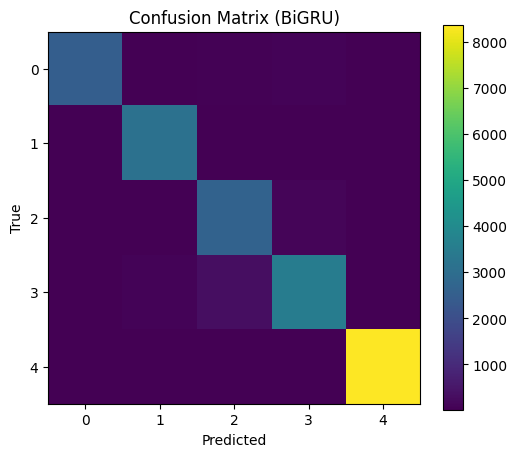

In [ ]:
val_probs = model.predict(X_val_pad, verbose=0)
val_pred_dl = np.argmax(val_probs, axis=1)

print("\n BiGRU  RESULTS ")
print(classification_report(y_val, val_pred_dl, digits=4))
print("Macro F1:", f1_score(y_val, val_pred_dl, average="macro"))
print("Weighted F1:", f1_score(y_val, val_pred_dl, average="weighted"))

cm2 = confusion_matrix(y_val, val_pred_dl)
plt.figure(figsize=(6,5))
plt.imshow(cm2, interpolation="nearest")
plt.title("Confusion Matrix (BiGRU)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **lSTM**

In [ ]:


model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=256, input_length=MAX_LEN),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

history = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=128,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

pred = np.argmax(model_lstm.predict(X_val_pad, verbose=0), axis=1)
print("LSTM Macro F1:", f1_score(y_val, pred, average="macro"))
print(classification_report(y_val, pred, digits=4))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.4559 - loss: 1.3233 - val_accuracy: 0.6163 - val_loss: 0.8594 - learning_rate: 0.0010
Epoch 2/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.5901 - loss: 1.1187 - val_accuracy: 0.7072 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 3/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.7804 - loss: 0.6811 - val_accuracy: 0.9308 - val_loss: 0.2396 - learning_rate: 0.0010
Epoch 4/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.9448 - loss: 0.2450 - val_accuracy: 0.9445 - val_loss: 0.1911 - learning_rate: 0.0010
Epoch 5/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9702 - loss: 0.1376 - val_accuracy: 0.9446 - val_loss: 0.1943 - learning_rate: 0.0010
Epoch 6/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.9817 - loss: 0.0888 - val_accuracy: 0.9465 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 7/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9893 - l

In [ ]:

model_big = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=256, input_length=MAX_LEN),
    tf.keras.layers.SpatialDropout1D(0.2),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_big.compile(
    optimizer=tf.keras.optimizers.Adam(2e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

history = model_big.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=12,
    batch_size=128,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

pred = np.argmax(model_big.predict(X_val_pad, verbose=0), axis=1)
print("BiLSTM+BiGRU Macro F1:", f1_score(y_val, pred, average="macro"))
print(classification_report(y_val, pred, digits=4))

Epoch 1/12


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


660/660 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.8263 - loss: 0.5196 - val_accuracy: 0.9550 - val_loss: 0.1434 - learning_rate: 0.0020
Epoch 2/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9757 - loss: 0.0998 - val_accuracy: 0.9528 - val_loss: 0.1601 - learning_rate: 0.0020
Epoch 3/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.9874 - loss: 0.0531 - val_accuracy: 0.9484 - val_loss: 0.1960 - learning_rate: 0.0020
Epoch 4/12
660/660 ━━━━━━━━━━━━━━━━━━━━ 50s 76ms/step - accuracy: 0.9945 - loss: 0.0235 - val_accuracy: 0.9522 - val_loss: 0.2134 - learning_rate: 0.0010
BiLSTM+BiGRU Macro F1: 0.9442353940624084
              precision    recall  f1-score   support

           0     0.9573    0.9552    0.9562      2699
           1     0.9469    0.9729    0.9597      3172
           2     0.8772    0.9246    0.9003      2812
           3     0.9327    0.8971    0.9145      3983
           4     0.9952    0.9857    0.9904      8452

    accuracy               

# **Transformer AraBERT**

In [ ]:
!pip -q install transformers datasets accelerate

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import classification_report, f1_score
import numpy as np

In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
tok = AutoTokenizer.from_pretrained(model_name)

# Oversample TRAIN (40k)
classes, counts = np.unique(y_train, return_counts=True)
freq = dict(zip(classes.tolist(), counts.tolist()))
inv = np.array([1.0 / freq[int(lbl)] for lbl in y_train], dtype=np.float64)
p = inv / inv.sum()

n_new = 40000
idx = np.random.RandomState(42).choice(np.arange(len(y_train)), size=n_new, replace=True, p=p)
X_train_os = X_train_text[idx]
y_train_os = y_train[idx]

print("Original train:", len(y_train), "Oversampled train:", len(y_train_os))

# Dataset
train_ds = Dataset.from_dict({"text": X_train_os.tolist(), "labels": y_train_os.tolist()})
val_ds   = Dataset.from_dict({"text": X_val_text.tolist(), "labels": y_val.tolist()})

# Lazy tokenize
train_ds.set_transform(lambda batch: {**tok(batch["text"], truncation=True, max_length=128), "labels": batch["labels"]})
val_ds.set_transform(lambda batch: {**tok(batch["text"], truncation=True, max_length=128), "labels": batch["labels"]})

collator = DataCollatorWithPadding(tokenizer=tok)

num_classes = len(np.unique(y))
model_tr = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

args = TrainingArguments(
    output_dir="./arabert_out",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_steps=100,
    report_to="none",
    fp16=True,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model_tr,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator
)

trainer.train()

pred_out = trainer.predict(val_ds)
pred = np.argmax(pred_out.predictions, axis=1)

print("Macro F1:", f1_score(y_val, pred, average="macro"))
print("Weighted F1:", f1_score(y_val, pred, average="weighted"))
print(classification_report(y_val, pred, digits=4))

Original train: 84468 Oversampled train: 40000


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: aubmindlab/bert-base-arabertv2
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider

Epoch,Training Loss,Validation Loss
1,0.188945,0.228594
2,0.155823,0.212683


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Macro F1: 0.944325170598154
Weighted F1: 0.9549090595864029
              precision    recall  f1-score   support

           0     0.9523    0.9626    0.9574      2699
           1     0.9596    0.9656    0.9626      3172
           2     0.8820    0.9200    0.9006      2812
           3     0.9241    0.8983    0.9110      3983
           4     0.9934    0.9865    0.9900      8452

    accuracy                         0.9548     21118
   macro avg     0.9423    0.9466    0.9443     21118
weighted avg     0.9552    0.9548    0.9549     21118

